# **Adaboost**

### **1. From Scratch**

In [160]:
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame()
     

df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]

df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


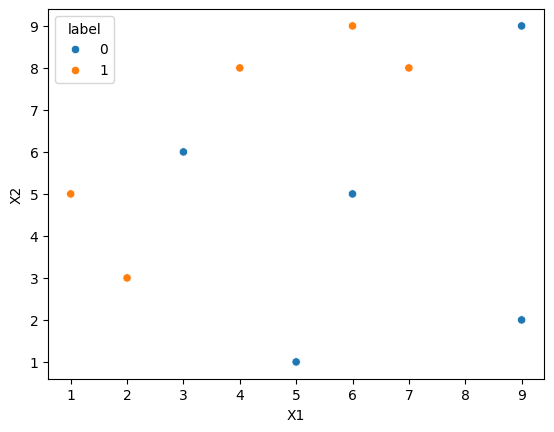

In [161]:
import seaborn as sns
sns.scatterplot(df,x=df['X1'],y=df['X2'],hue=df['label']);

In [162]:
# Step 1 : Assign the weights
df['weights'] = 1/len(df)
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [163]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values

In [164]:
# Step 2 : Train the 1st model
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X,y)

DecisionTreeClassifier(max_depth=1)

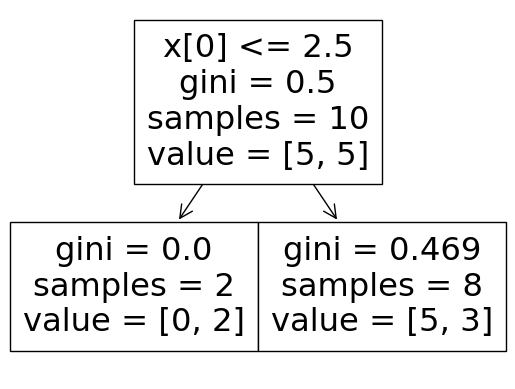

In [165]:
from sklearn.tree import plot_tree
plot_tree(dt1);

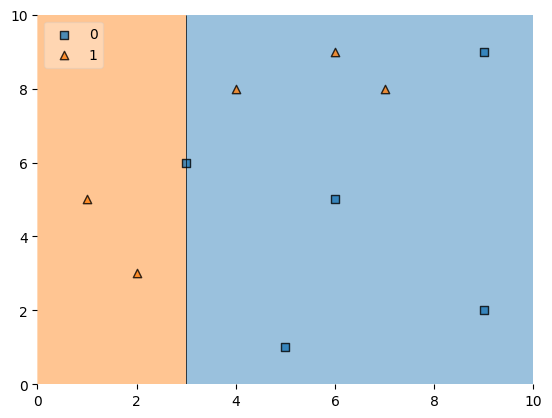

In [166]:
plot_decision_regions(X, y, clf=dt1, legend=2);

In [167]:
# Step 3 : Pridict the model
df['Y_Pred'] = dt1.predict(X)
df

,X1,X2,label,weights,Y_Pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


In [168]:
# Step 4 : Calculate the model weight
def calculate_model_weight(error):

 return 0.5 * np.log((1-error)/(error))

alpha1 = calculate_model_weight(0.3)
print(alpha1)

0.42364893019360184


In [169]:
# Step 5 : Update weights
def update_row_weights(row,alpha=0.423):
  if row['label'] == row['Y_Pred']:
    return row['weights'] * np.exp(-alpha)
  else:
    return row['weights'] * np.exp(alpha)

In [170]:
df['updated_weights'] = df.apply(update_row_weights, axis=1)
df

,X1,X2,label,weights,Y_Pred,updated_weights
0,1,5,1,0.1,1,0.065508
1,2,3,1,0.1,1,0.065508
2,3,6,0,0.1,0,0.065508
3,4,8,1,0.1,0,0.152653
4,5,1,0,0.1,0,0.065508
5,6,9,1,0.1,0,0.152653
6,6,5,0,0.1,0,0.065508
7,7,8,1,0.1,0,0.152653
8,9,9,0,0.1,0,0.065508
9,9,2,0,0.1,0,0.065508


In [171]:
df['updated_weights'].sum()

0.9165153319682015

In [172]:
df['nomalized_weights'] = df['updated_weights'] / df['updated_weights'].sum()
df

,X1,X2,label,weights,Y_Pred,updated_weights,nomalized_weights
0,1,5,1,0.1,1,0.065508,0.071475
1,2,3,1,0.1,1,0.065508,0.071475
2,3,6,0,0.1,0,0.065508,0.071475
3,4,8,1,0.1,0,0.152653,0.166559
4,5,1,0,0.1,0,0.065508,0.071475
5,6,9,1,0.1,0,0.152653,0.166559
6,6,5,0,0.1,0,0.065508,0.071475
7,7,8,1,0.1,0,0.152653,0.166559
8,9,9,0,0.1,0,0.065508,0.071475
9,9,2,0,0.1,0,0.065508,0.071475


In [173]:
df['nomalized_weights'].sum()

1.0

In [174]:
# Step 6 : Find the upper and lower limits of our normalized weights

# upper limit
df['cumsum_upper'] = np.cumsum(df['nomalized_weights'])

# lower limit
df['cumsum_lower'] = df['cumsum_upper'] - df['nomalized_weights']

# arrange he columns
df[['X1','X2','label','weights','Y_Pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weights,Y_Pred,updated_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.065508,0.000000,0.071475
1,2,3,1,0.1,1,0.065508,0.071475,0.142950
2,3,6,0,0.1,0,0.065508,0.142950,0.214425
3,4,8,1,0.1,0,0.152653,0.214425,0.380983
4,5,1,0,0.1,0,0.065508,0.380983,0.452458
5,6,9,1,0.1,0,0.152653,0.452458,0.619017
6,6,5,0,0.1,0,0.065508,0.619017,0.690492
7,7,8,1,0.1,0,0.152653,0.690492,0.857050
8,9,9,0,0.1,0,0.065508,0.857050,0.928525
9,9,2,0,0.1,0,0.065508,0.928525,1.000000


In [175]:
# Step 7 : Create the new data set 
def create_new_dataset(df):

  indices = []

  for i in range(df.shape[0]):
    a = np.random.random()
    for index,row in df.iterrows():
      if row['cumsum_upper'] > a and a > row['cumsum_lower']:
        indices.append(index)
  return indices

In [176]:
index_values = create_new_dataset(df)

index_values

[7, 2, 7, 5, 4, 1, 5, 3, 1, 6]

In [177]:
second_df = df.iloc[index_values,[0,1,2,3]]

second_df

,X1,X2,label,weights
7,7,8,1,0.1
2,3,6,0,0.1
7,7,8,1,0.1
5,6,9,1,0.1
4,5,1,0,0.1
1,2,3,1,0.1
5,6,9,1,0.1
3,4,8,1,0.1
1,2,3,1,0.1
6,6,5,0,0.1


`Repeat all the above steps  (for upsampling) for as many times as the number of Decision Stumps required.`

### **2. Using Sklearn**

In [178]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)

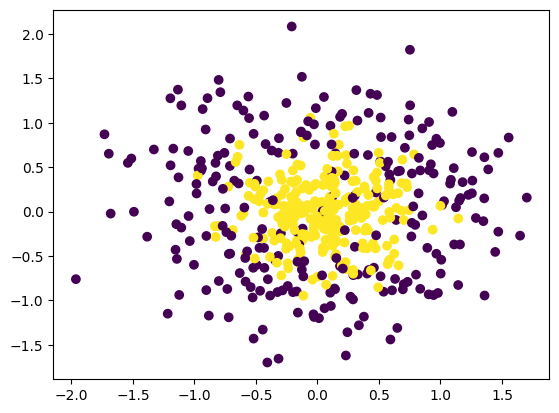

In [183]:
plt.scatter(X[:,0],X[:,1],c=y);

In [184]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

abc = AdaBoostClassifier()

np.mean(cross_val_score(abc,X,y,scoring='accuracy',cv=10))

0.786